<a href="https://colab.research.google.com/github/MNabildawami/deteksiface/blob/main/deteksiface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install pyheif


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 21.5 MB/s eta 0:00:00


In [15]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


SVM Model Accuracy: 66.67%

Classification Report:
              precision    recall  f1-score   support

       Fajri       1.00      1.00      1.00         3
      Gilang       1.00      0.50      0.67         2
       Surya       0.25      1.00      0.40         1
       nabil       1.00      0.33      0.50         3

    accuracy                           0.67         9
   macro avg       0.81      0.71      0.64         9
weighted avg       0.92      0.67      0.69         9



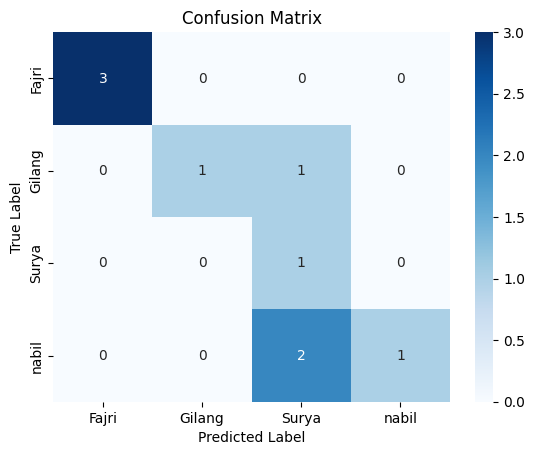

Image at /content/drive/MyDrive/footage item pengpol/data_uji/fajri1.jpg could not be loaded.
No face detected in test image!


In [36]:
import cv2
import dlib
import os
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import pyheif
from PIL import Image
import io
import matplotlib.pyplot as plt
import seaborn as sns

# Download and extract the model file if not already extracted
model_path = "shape_predictor_68_face_landmarks.dat"
if not os.path.exists(model_path):
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

# Load face detector and landmark predictor model
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(model_path)

# Function to extract face landmarks data
def extract_face_landmarks_data(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    if len(faces) == 0:
        print("No faces detected.")
        return None

    landmarks_data = []
    for face in faces:
        landmarks = predictor(gray, face)
        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            landmarks_data.append((x, y))  # Add (x, y) coordinates to list
    return landmarks_data

# Function to read HEIC images
def read_heic_image(heic_file):
    heif_file = pyheif.read(heic_file)
    image = Image.open(io.BytesIO(heif_file.data))
    return np.array(image)

# Function to process images in folder
def process_folder_images(folder_path):
    data = []
    labels = []

    if not os.path.exists(folder_path):
        print(f"Folder {folder_path} does not exist!")
        return None, None

    # Loop through all subfolders in the main folder
    for folder_name in os.listdir(folder_path):
        folder = os.path.join(folder_path, folder_name)

        if os.path.isdir(folder):
            # Loop through all images in the subfolder
            for file_name in os.listdir(folder):
                file_path = os.path.join(folder, file_name)

                if file_name.lower().endswith(('.jpg', '.jpeg', '.png', '.heic')):  # Filter image files
                    try:
                        if file_name.lower().endswith('.heic'):
                            image = read_heic_image(file_path)
                        else:
                            image = cv2.imread(file_path)

                        if image is None:
                            print(f"Image {file_name} not found or could not be loaded!")
                            continue

                        landmarks_data = extract_face_landmarks_data(image)

                        if landmarks_data is not None:
                            flattened_landmarks = [coord for point in landmarks_data for coord in point]
                            data.append(flattened_landmarks)
                            labels.append(folder_name)

                    except Exception as e:
                        print(f"Error processing {file_name}: {e}")
                        continue

    # Create dataframe for the data
    column_names = [f'x{i+1}' for i in range(68)] + [f'y{i+1}' for i in range(68)]
    df = pd.DataFrame(data, columns=column_names)

    return df, labels

# Define predict_image function
def predict_image(image_path):
    image = cv2.imread(image_path)

    if image is None:
        print(f"Image at {image_path} could not be loaded.")
        return None

    landmarks_data = extract_face_landmarks_data(image)

    if landmarks_data is None:
        print("No face detected in the image!")
        return None

    flattened_landmarks = [coord for point in landmarks_data for coord in point]
    predicted_name = svm_classifier.predict([flattened_landmarks])

    return predicted_name[0]

# Set folder paths for training and testing data
train_folder_path = '/content/drive/MyDrive/footage item pengpol /data_latih'
test_folder_path = '/content/drive/MyDrive/footage item pengpol/data_uji'

# Ensure that the training folder exists
if not os.path.exists(train_folder_path):
    print(f"Training folder '{train_folder_path}' does not exist.")
else:
    # Process all images in the training folder
    landmarks_df, labels = process_folder_images(train_folder_path)

    if landmarks_df is not None:
        # Split dataset into training and testing sets (70% training, 30% testing)
        X_train, X_test, y_train, y_test = train_test_split(landmarks_df, labels, test_size=0.3, random_state=42)

        # Handle class imbalance using SMOTE
        smote = SMOTE(random_state=42, k_neighbors=1)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        # Train an SVM classifier with RBF kernel
        svm_classifier = SVC(kernel='rbf', gamma='scale')
        svm_classifier.fit(X_train_resampled, y_train_resampled)

        # Predict labels for test data
        y_pred = svm_classifier.predict(X_test)

        # Evaluate the classifier
        accuracy = accuracy_score(y_test, y_pred)
        print(f"SVM Model Accuracy: {accuracy * 100:.2f}%")

        # Display classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Display confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(labels), yticklabels=np.unique(labels))
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

        # Test with an image
        test_image_path = '/content/drive/MyDrive/footage item pengpol/data_uji/fajri1.jpg'
        predicted_name = predict_image(test_image_path)

        if predicted_name:
            print(f"Predicted Name: {predicted_name}")
        else:
            print("No face detected in test image!")
